# OpenAI API Test Notebook

## Count and sample from labeled dataset

In [29]:
import json
import random
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import base64
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm
import re

In [4]:
HAND_LABELED_PATH = "../hand_labeled_annotations.json"
SAMPLED_OUT_PATH = "../sample_100_for_openai.json"

with open(HAND_LABELED_PATH) as f:
    data = json.load(f)

combo_counts = Counter((d["turn_signal"], d["tail_light"]) for d in data)
print("Class distribution:")
for combo, count in combo_counts.items():
    print(f"{combo}: {count}")

Class distribution:
('none', 'off'): 7994
('none', 'on'): 1617
('none', 'not_visible'): 229
('right', 'off'): 52
('left', 'off'): 69
('left', 'on'): 17
('right', 'on'): 22


In [5]:
sampling_scheme = {
    ("none", "off"): 25,
    ("none", "on"): 25,
    ("left", "on"): 10,
    ("left", "off"): 10,
    ("right", "off"): 10,
    ("right", "on"): 10,
    ("none", "not_visible"): 10
}

In [6]:
# sampled = []
# for combo, n in sampling_scheme.items():
#     subset = [d for d in data if (d["turn_signal"], d["tail_light"]) == combo]
#     if len(subset) < n:
#         print(f"Only found {len(subset)} samples for {combo}, taking all available.")
#     sampled.extend(random.sample(subset, min(len(subset), n)))

# print(f"\nTotal sampled: {len(sampled)}")
# with open(SAMPLED_OUT_PATH, "w") as f:
#     json.dump(sampled, f, indent=2)
# print(f"Saved sampled subset to {SAMPLED_OUT_PATH}")


Total sampled: 100
Saved sampled subset to ../sample_100_for_openai.json


## Run the OpenAI API on the sampled images

In [19]:
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

SAMPLED_PATH = "../sample_100_for_openai.json"
OUTPUT_FILE = "openai_light_predictions.json"
LOCAL_BASE = "../sampled_images" 

In [20]:
def encode_image(image_path):
    with open(image_path, "rb") as img:
        return base64.b64encode(img.read()).decode("utf-8")

In [36]:
def classify_image(local_path):
    img_b64 = encode_image(local_path)
    prompt = {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are an image analysis model. Look at the car image and determine:\n"
                    "1. turn_signal — one of: left, right, none, both\n"
                    "2. tail_light — one of: on, off, not_visible\n\n"
                    "Return only valid JSON in this format:\n"
                    "{\n"
                    "  \"turn_signal\": \"left\",\n"
                    "  \"tail_light\": \"on\"\n"
                    "}"
                ),
            },
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}}
        ],
    }

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[prompt],
            temperature=0,
            response_format={"type": "json_object"}, 
        )
        return json.loads(response.choices[0].message.content)
    except Exception as e:
        print(f"Error processing {local_path}: {e}")
        return {"turn_signal": "none", "tail_light": "not_visible"}

In [37]:
with open(SAMPLED_PATH) as f:
    sampled = json.load(f)

In [39]:
results = []
for entry in tqdm(sampled[0:2], desc="Classifying images"): # [0:2] to run through all
    local_path = os.path.join(LOCAL_BASE, entry["image"].lstrip("/"))
    print(local_path)
    result = classify_image(local_path)
    results.append({
        "image": entry["image"],
        "hand_label": {
            "turn_signal": entry["turn_signal"],
            "tail_light": entry["tail_light"]
        },
        "openai_label": result
    })

with open(OUTPUT_FILE, "w") as f:
    json.dump(results, f, indent=2)

print(f"\nDone! Saved {len(results)} results to {OUTPUT_FILE}")

Classifying images:   0%|                                 | 0/2 [00:00<?, ?it/s]

../sampled_images/gpfs/space/projects/ml2024/2024-08-16-16-12-55_mapping_tartu_streets/camera_wide_front/predict/crops/car/148476.jpg


Classifying images:  50%|████████████▌            | 1/2 [00:01<00:01,  1.60s/it]

../sampled_images/gpfs/space/projects/ml2024/2024-08-16-13-00-58_mapping_tartu_streets/camera_narrow_front/predict/crops/car/033447.jpg


Classifying images: 100%|█████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


Done! Saved 2 results to openai_light_predictions.json


## Display results side-by-side

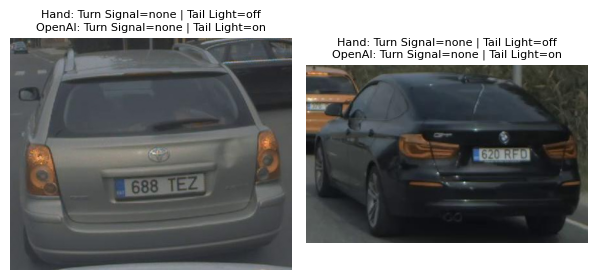

In [42]:
RESULTS_PATH = "openai_light_predictions.json"
LOCAL_BASE = "../sampled_images"

with open(RESULTS_PATH) as f:
    results = json.load(f)

# Display 12 images per page
for i, entry in enumerate(results[:100]):
    if i % 12 == 0:
        plt.figure(figsize=(12, 10))
    plt.subplot(3, 4, (i % 12) + 1)
    img_path = os.path.join(LOCAL_BASE, entry["image"].lstrip("/"))
    try:
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"Hand: Turn Signal={entry['hand_label']['turn_signal']} | Tail Light={entry['hand_label']['tail_light']}\n"
            f"OpenAI: Turn Signal={entry['openai_label']['turn_signal']} | Tail Light={entry['openai_label']['tail_light']}",
            fontsize=8
        )
    except Exception as e:
        plt.title(f"Missing image: {e}")
    if (i + 1) % 12 == 0 or i == len(results) - 1:
        plt.tight_layout()
        plt.show()

## Metrics comparison

In [44]:
with open("openai_light_predictions.json") as f:
    results = json.load(f)

total = len(results)
turn_correct = sum(r["hand_label"]["turn_signal"] == r["openai_label"]["turn_signal"] for r in results)
tail_correct = sum(r["hand_label"]["tail_light"] == r["openai_label"]["tail_light"] for r in results)

print(f"Turn signal accuracy: {turn_correct / total:.2%}")
print(f"Tail light accuracy: {tail_correct / total:.2%}")

Turn signal accuracy: 100.00%
Tail light accuracy: 0.00%
